In [354]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import sympify, symbols, lambdify


# Wpisywanie żądanej funkcji 

In [355]:

# Definiowanie zmiennej symbolicznej
x = symbols('x')

print("Wprowadź funkcję jednoargumentową, np.: 5*x**2 + sinx")
user_function = input("f(x) = ")

try:
    # Parsowanie funkcji podanej przez użytkownika
    parsed_function = sympify(user_function)
    print(f"Twoja funkcja: f(x) = {parsed_function}")

    # Tworzenie funkcji, którą można wywoływać
    func = lambdify(x, parsed_function, modules=["numpy"])  # Użycie numpy zamiast math

except Exception as e:
    print(f"Błąd w podanej funkcji: {e}")


Wprowadź funkcję jednoargumentową, np.: 5*x**2 + sinx
Twoja funkcja: f(x) = x**2 + 5*sin(x)


# Funkcja dostosowania

In [356]:
# Funkcja fitness - minimalizujemy dowolną funkcję jednoargumentową
def fitness_function(x):
    return func(x)

# Parametry

In [357]:
# Parametry algorytmu genetycznego
POPULATION_SIZE = 100
CHROMOSOME_LENGTH = 16  # Liczba bitów w chromosomie
MUTATION_RATE = 0.01
CROSSOVER_RATE = 0.7
GENERATIONS = 50
BOUND_LOW, BOUND_HIGH = -8, 8


In [358]:
# Dekodowanie chromosomu binarnego na wartość rzeczywistą.
def decode_chromosome(chromosome, CHROMOSOME_LENGTH):
    integer_value = int("".join(map(str, chromosome)), 2)
    max_integer = 2**CHROMOSOME_LENGTH - 1
    return BOUND_LOW + (BOUND_HIGH - BOUND_LOW) * (integer_value / max_integer)

# Tworzenie populacji 

In [359]:
def initialize_population(POPULATION_SIZE, CHROMOSOME_LENGTH):
    return np.random.randint(2, size=(POPULATION_SIZE, CHROMOSOME_LENGTH))

# Ocena populacji

In [360]:
def evaluate_population(population, CHROMOSOME_LENGTH):
    decoded = np.array([decode_chromosome(c, CHROMOSOME_LENGTH) for c in population])
    return fitness_function(decoded)

# Selekcja

In [361]:
def roulette_wheel_selection(population, fitness, POPULATION_SIZE):
    # Selekcja rulteki 
    # Przekształcenie fitness na wartości dopasowania - odwrotność (bo minimalizujemy)
    adjusted_fitness = 1 / (1 + fitness - np.min(fitness))
    total_fitness = np.sum(adjusted_fitness)
    probabilities = adjusted_fitness / total_fitness

    indices = np.random.choice(len(population), size=POPULATION_SIZE, p=probabilities)
    selected = population[indices]
    return selected

def tournament_selection(population, fitness, POPULATION_SIZE):
    # Turniejowy wybór rodziców
    selected = []
    for _ in range(POPULATION_SIZE):
        i, j = np.random.randint(0, POPULATION_SIZE, 2)
        winner = population[i] if fitness[i] < fitness[j] else population[j]
        selected.append(winner)
    return np.array(selected)

def ranking_selection(population, fitness, POPULATION_SIZE):
    adjusted_fitness = 1 / (1 + fitness - np.min(fitness))
    sorted_indices = np.argsort(adjusted_fitness)
    ranked_population = population[sorted_indices]
    
    ranks = np.arange(1, POPULATION_SIZE + 1)
    
    selected = []
    for _ in range(POPULATION_SIZE):
        selected_index = np.random.choice(POPULATION_SIZE, p=ranks / np.sum(ranks))
        selected.append(ranked_population[selected_index])
    
    return np.array(selected)

# Krzyżowanie

In [362]:
def crossover(parents, POPULATION_SIZE, CROSSOVER_RATE, CHROMOSOME_LENGTH):
    # Jednopunktowe krzyżowanie
    offspring = []
    for i in range(0, POPULATION_SIZE, 2):
        parent1, parent2 = parents[i], parents[i + 1]
        if np.random.rand() < CROSSOVER_RATE:
            point = np.random.randint(1, CHROMOSOME_LENGTH - 1)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            offspring.extend([child1, child2])
        else:
            offspring.extend([parent1, parent2])
    return np.array(offspring)

def crossover_with_mask(parents, POPULATION_SIZE, CROSSOVER_RATE, CHROMOSOME_LENGTH):
    # Krzyżowanie z maską
    offspring = []
    for i in range(0, POPULATION_SIZE, 2):
        parent1, parent2 = parents[i], parents[i + 1]
        if np.random.rand() < CROSSOVER_RATE:
            # Generowanie losowej maski (tablica 0 i 1)
            mask = np.random.randint(0, 2, size=CHROMOSOME_LENGTH)
            # Tworzenie dzieci na podstawie maski
            child1 = np.where(mask == 1, parent1, parent2)
            child2 = np.where(mask == 1, parent2, parent1)
            offspring.extend([child1, child2])
        else:
            offspring.extend([parent1, parent2])
    return np.array(offspring)


# Mutacja

In [363]:
def mutate(population, CHROMOSOME_LENGTH, MUTATION_RATE):
    for individual in population:
        for gene in range(CHROMOSOME_LENGTH):
            if np.random.rand() < MUTATION_RATE:
                individual[gene] = 1 - individual[gene]
    return population

# Algorytm 

In [364]:
def genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, STALL_GENERATIONS=10, sel_func=roulette_wheel_selection, cros_func=crossover):
    population = initialize_population(POPULATION_SIZE, CHROMOSOME_LENGTH)
    best_fitness = []
    best_individuals = []
    gen = 0

    for generation in range(GENERATIONS):
        gen += 1
        fitness = evaluate_population(population, CHROMOSOME_LENGTH)
        best_fitness.append(np.min(fitness))
        best_individual = population[np.argmin(fitness)]
        best_individuals.append(decode_chromosome(best_individual, CHROMOSOME_LENGTH))

        # Warunek stopu: brak poprawy w ciągu STALL_GENERATIONS pokoleń
        if generation > 0 and np.min(fitness) == best_fitness[-2]:
            stagnation_count += 1
        else:
            stagnation_count = 0
        
        if stagnation_count >= STALL_GENERATIONS:
            print(f"Stop: Brak poprawy w ciągu {STALL_GENERATIONS} pokoleń w pokoleniu {generation}.")
            break

        selected = sel_func(population, fitness, POPULATION_SIZE)
        offspring = cros_func(selected, POPULATION_SIZE, CROSSOVER_RATE, CHROMOSOME_LENGTH)
        population = mutate(offspring, CHROMOSOME_LENGTH, MUTATION_RATE)

    return best_fitness, best_individuals, gen

# Wyniki 

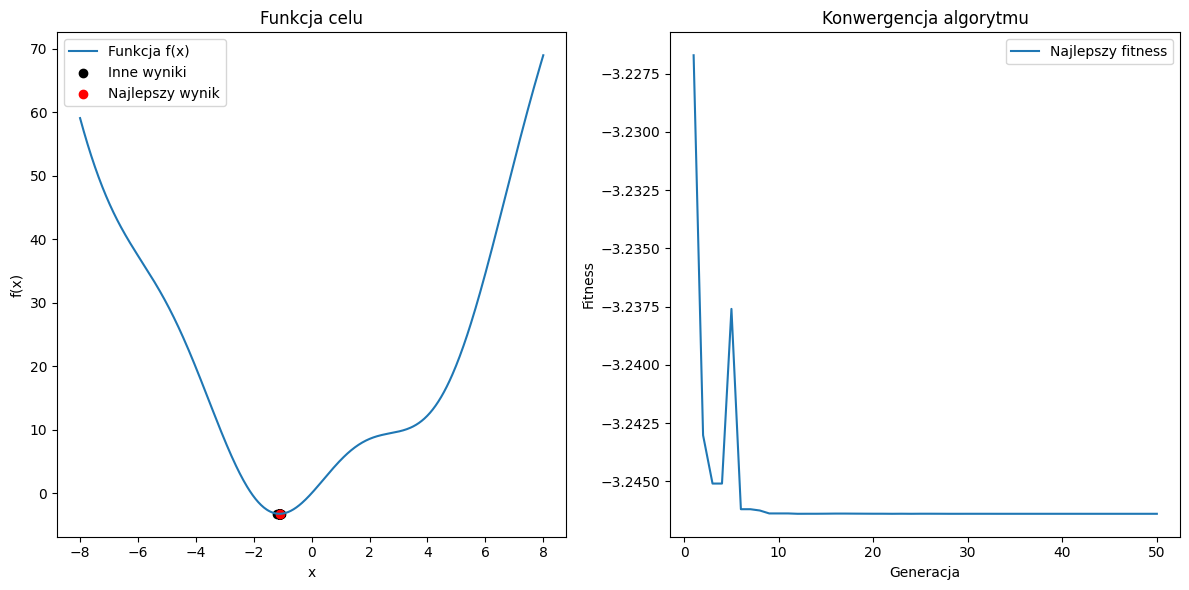

In [365]:
best_fitness, best_individuals, gen = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, sel_func=tournament_selection, cros_func=crossover_with_mask)

x = np.linspace(BOUND_LOW, BOUND_HIGH, 500)
y = fitness_function(x)

plt.figure(figsize=(12, 6))

# Wykres funkcji i najlepszego wyniku
plt.subplot(1, 2, 1)
plt.plot(x, y, label="Funkcja f(x)")
plt.scatter(best_individuals, best_fitness, color='black', label='Inne wyniki')
plt.scatter(best_individuals[-1], fitness_function(best_individuals[-1]), color='red', label="Najlepszy wynik")
plt.title("Funkcja celu")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()

# Wykres konwergencji
plt.subplot(1, 2, 2)
plt.plot(range(1, gen + 1), best_fitness, label="Najlepszy fitness")
plt.title("Konwergencja algorytmu")
plt.xlabel("Generacja")
plt.ylabel("Fitness")
plt.legend()

plt.tight_layout()
plt.show()

Stop: Brak poprawy w ciągu 10 pokoleń w pokoleniu 10.


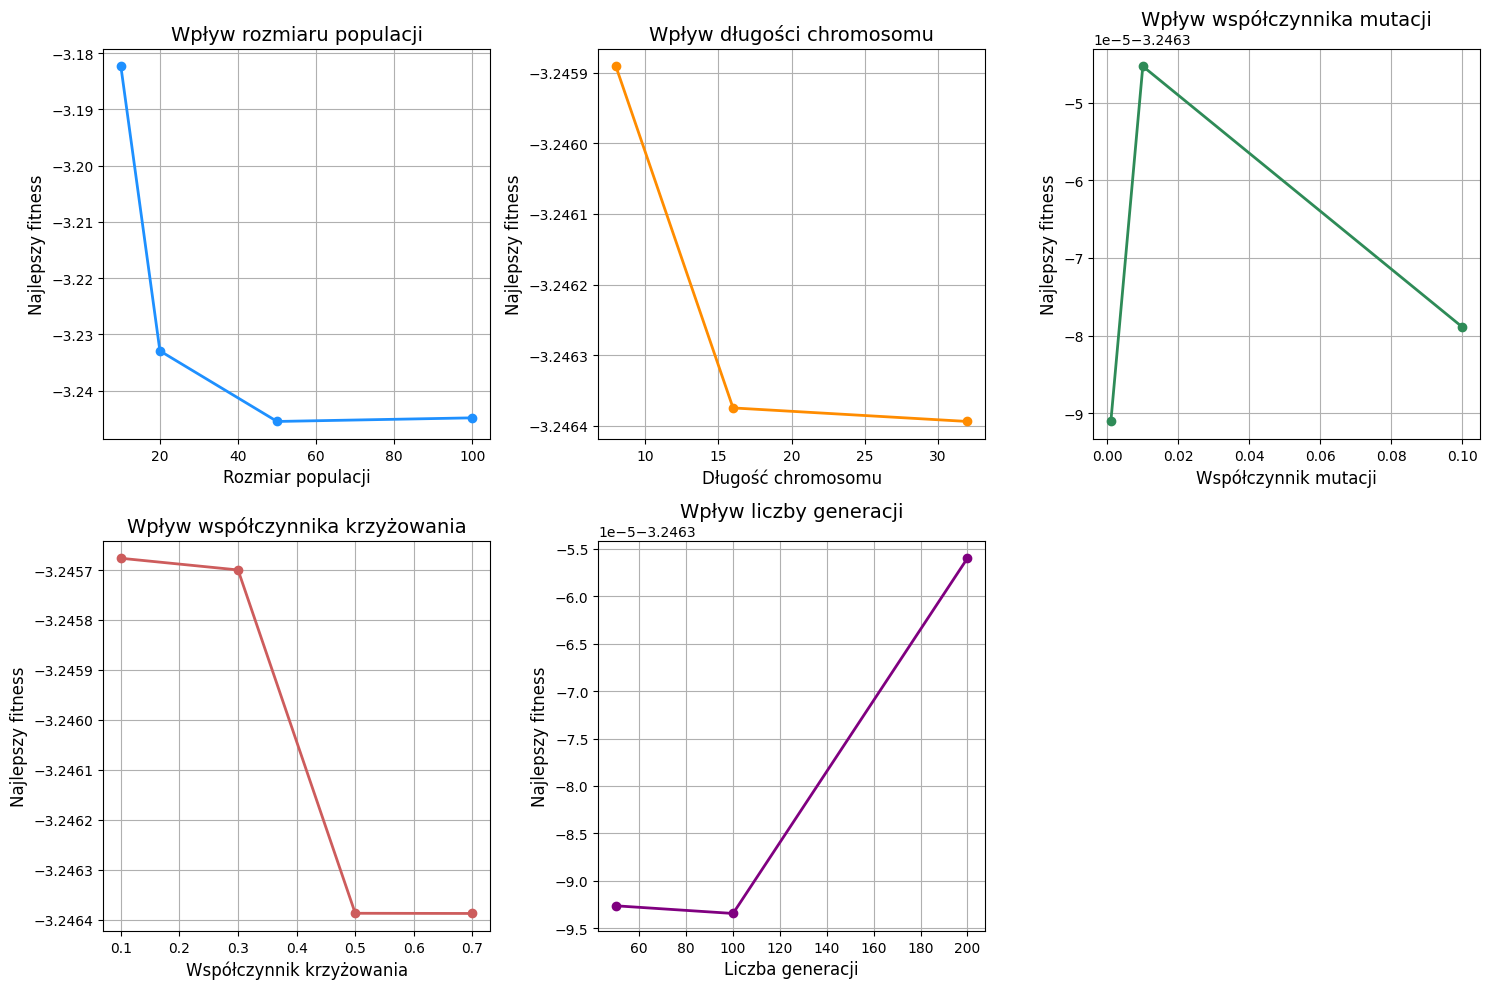

In [366]:
# Eksperyment z różnymi wartościami parametrów

# 1. Zmienność rozmiaru populacji
population_sizes = [10, 20, 50, 100]
best_fitness_pop_size = []

for pop_size in population_sizes:
    best_fitness, _, gen = genetic_algorithm(pop_size, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS)
    best_fitness_pop_size.append(best_fitness[-1])  # najlepszy fitness ostatniej generacji

# 2. Zmienność długości chromosomu
chromosome_lengths = [8, 16, 32]
best_fitness_chrom_length = []

for chrom_len in chromosome_lengths:
    best_fitness, _, gen = genetic_algorithm(POPULATION_SIZE, chrom_len, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS)
    best_fitness_chrom_length.append(best_fitness[-1])

# 3. Zmienność współczynnika mutacji
mutation_rates = [0.001, 0.01, 0.1]
best_fitness_mut_rate = []

for mut_rate in mutation_rates:
    best_fitness, _,gen = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, mut_rate, CROSSOVER_RATE, GENERATIONS)
    best_fitness_mut_rate.append(best_fitness[-1])

# 4. Zmienność współczynnika krzyżowania
crossover_rates = [0.1, 0.3, 0.5, 0.7]
best_fitness_cross_rate = []

for cross_rate in crossover_rates:
    best_fitness, _ , gen= genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, cross_rate, GENERATIONS)
    best_fitness_cross_rate.append(best_fitness[-1])

# 5. Zmienność liczby generacji
generations_list = [50, 100, 200]
best_fitness_generations = []

for gen in generations_list:
    best_fitness, _, gen1 = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, gen)
    best_fitness_generations.append(best_fitness[-1])

# Wizualizacja wyników

plt.figure(figsize=(15, 10))

# 1. Wykres rozmiaru populacji
plt.subplot(2, 3, 1)
plt.plot(population_sizes, best_fitness_pop_size, marker='o', color='dodgerblue', linestyle='-', linewidth=2)
plt.title("Wpływ rozmiaru populacji", fontsize=14)
plt.xlabel("Rozmiar populacji", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.grid(True)

# 2. Wykres długości chromosomu
plt.subplot(2, 3, 2)
plt.plot(chromosome_lengths, best_fitness_chrom_length, marker='o', color='darkorange', linestyle='-', linewidth=2)
plt.title("Wpływ długości chromosomu", fontsize=14)
plt.xlabel("Długość chromosomu", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.grid(True)

# 3. Wykres współczynnika mutacji
plt.subplot(2, 3, 3)
plt.plot(mutation_rates, best_fitness_mut_rate, marker='o', color='seagreen', linestyle='-', linewidth=2)
plt.title("Wpływ współczynnika mutacji", fontsize=14)
plt.xlabel("Współczynnik mutacji", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.grid(True)

# 4. Wykres współczynnika krzyżowania
plt.subplot(2, 3, 4)
plt.plot(crossover_rates, best_fitness_cross_rate, marker='o', color='indianred', linestyle='-', linewidth=2)
plt.title("Wpływ współczynnika krzyżowania", fontsize=14)
plt.xlabel("Współczynnik krzyżowania", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.grid(True)

# 5. Wykres liczby generacji
plt.subplot(2, 3, 5)
plt.plot(generations_list, best_fitness_generations, marker='o', color='purple', linestyle='-', linewidth=2)
plt.title("Wpływ liczby generacji", fontsize=14)
plt.xlabel("Liczba generacji", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

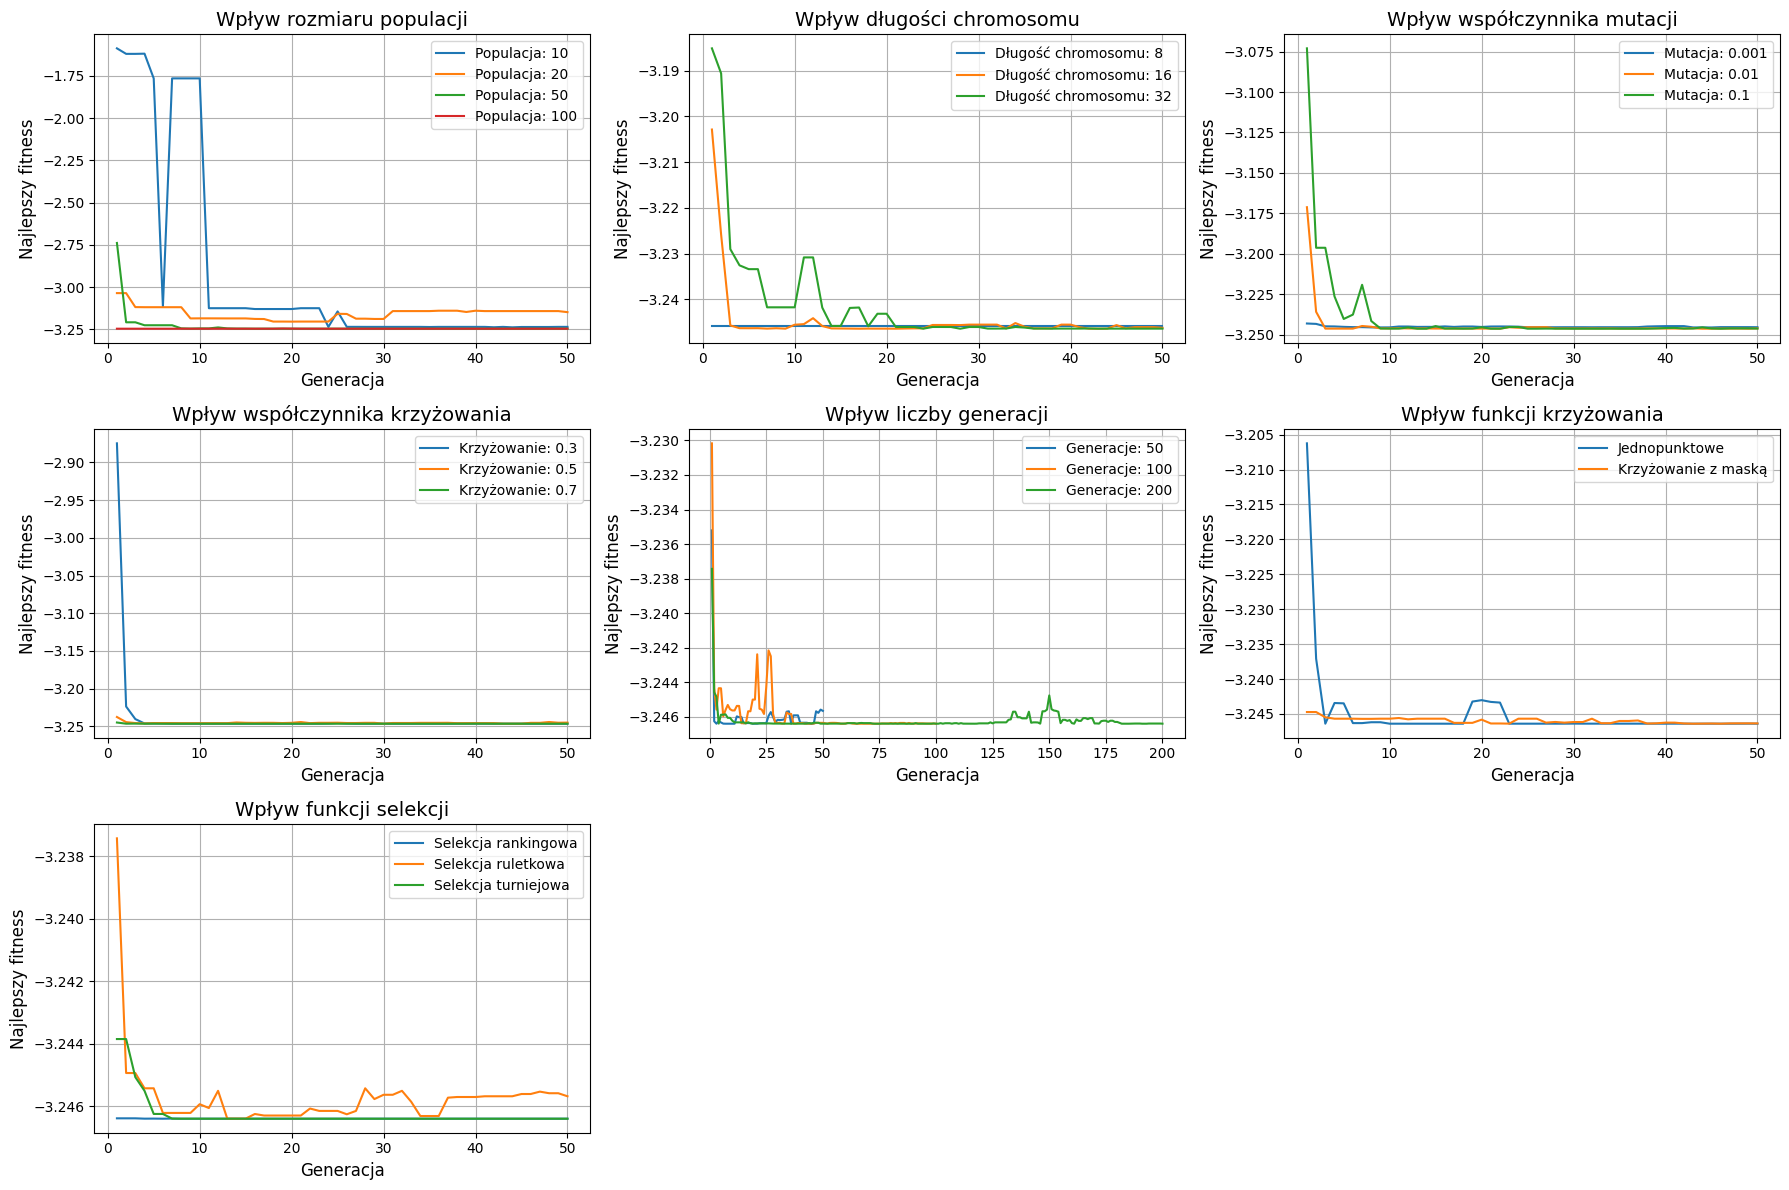

In [367]:
# Parametry do testów
population_sizes = [10, 20, 50, 100]
chromosome_lengths = [8, 16, 32]
mutation_rates = [0.001, 0.01, 0.1]
crossover_rates = [0.3, 0.5, 0.7]
selection_funcs = [ranking_selection, roulette_wheel_selection, tournament_selection]
crossover_funcs = [crossover, crossover_with_mask]

# Wykresy
plt.figure(figsize=(18, 12))

# 1. Wykres dla różnych rozmiarów populacji
plt.subplot(3, 3, 1)
for pop_size in population_sizes:
    best_fitness, best_individuals, g = genetic_algorithm(pop_size, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, STALL_GENERATIONS=100)
    plt.plot(range(1, GENERATIONS + 1), best_fitness, label=f'Populacja: {pop_size}')
plt.title("Wpływ rozmiaru populacji", fontsize=14)
plt.xlabel("Generacja", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.legend()
plt.grid(True)

# 2. Wykres dla różnych długości chromosomu
plt.subplot(3, 3, 2)
for chrom_len in chromosome_lengths:
    best_fitness, best_individuals, g = genetic_algorithm(POPULATION_SIZE, chrom_len, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, STALL_GENERATIONS=100)
    plt.plot(range(1, GENERATIONS + 1), best_fitness, label=f'Długość chromosomu: {chrom_len}')
plt.title("Wpływ długości chromosomu", fontsize=14)
plt.xlabel("Generacja", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.legend()
plt.grid(True)

# 3. Wykres dla różnych współczynników mutacji
plt.subplot(3, 3, 3)
for mut_rate in mutation_rates:
    best_fitness, best_individuals, g = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, mut_rate, CROSSOVER_RATE, GENERATIONS, STALL_GENERATIONS=100)
    plt.plot(range(1, GENERATIONS + 1), best_fitness, label=f'Mutacja: {mut_rate}')
plt.title("Wpływ współczynnika mutacji", fontsize=14)
plt.xlabel("Generacja", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.legend()
plt.grid(True)

# 4. Wykres dla różnych współczynników krzyżowania
plt.subplot(3, 3, 4)
for cross_rate in crossover_rates:
    best_fitness, best_individuals, g = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, cross_rate, GENERATIONS, STALL_GENERATIONS=100)
    plt.plot(range(1, GENERATIONS + 1), best_fitness, label=f'Krzyżowanie: {cross_rate}')
plt.title("Wpływ współczynnika krzyżowania", fontsize=14)
plt.xlabel("Generacja", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.legend()
plt.grid(True)

# 5. Wykres dla różnych liczby generacji
generations_list = [50, 100, 200]
plt.subplot(3, 3, 5)
for gen in generations_list:
    best_fitness, best_individuals, g = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, gen, STALL_GENERATIONS=100)
    plt.plot(range(1, gen + 1), best_fitness, label=f'Generacje: {gen}')
plt.title("Wpływ liczby generacji", fontsize=14)
plt.xlabel("Generacja", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 6)
for crossover_func in crossover_funcs:
    best_fitness, best_individuals, g = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, cros_func=crossover_func, STALL_GENERATIONS=100)
    label = "Jednopunktowe" if crossover_func == crossover else "Krzyżowanie z maską"
    plt.plot(range(1, GENERATIONS + 1), best_fitness, label=f'{label}')
plt.title("Wpływ funkcji krzyżowania", fontsize=14)
plt.xlabel("Generacja", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.legend()
plt.grid(True)

# 2. Wykres dla różnych funkcji selekcji
plt.subplot(3, 3, 7)
for sel_func in selection_funcs:
    best_fitness, best_individuals, g = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, sel_func=sel_func, STALL_GENERATIONS=100)
    label = "Selekcja rankingowa" if sel_func == ranking_selection else ("Selekcja ruletkowa" if sel_func == roulette_wheel_selection else "Selekcja turniejowa")
    plt.plot(range(1, GENERATIONS + 1), best_fitness, label=f'{label}')
plt.title("Wpływ funkcji selekcji", fontsize=14)
plt.xlabel("Generacja", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

Stop: Brak poprawy w ciągu 10 pokoleń w pokoleniu 39.


C:\Users\aleks\AppData\Local\Temp\ipykernel_9892\2150282764.py:101: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


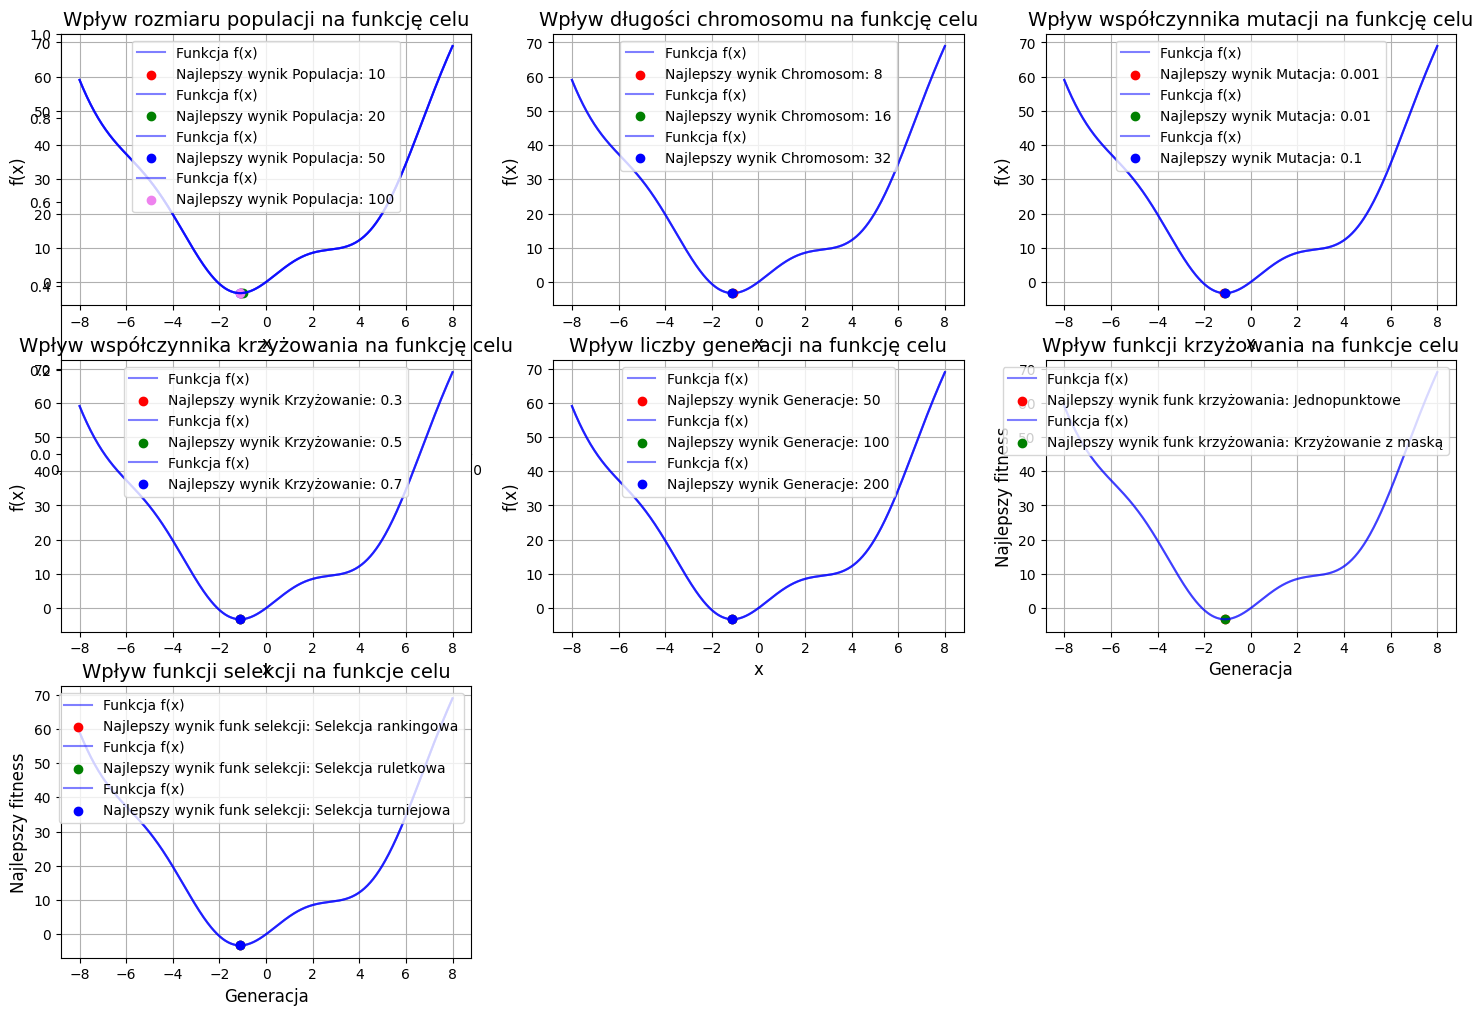

In [368]:
# Przygotowanie wykresów
plt.figure(figsize=(18, 12))

# 1. Wykres funkcji celu i najlepszego wyniku dla różnych rozmiarów populacji
plt.subplot(2, 3, 1)
x = np.linspace(BOUND_LOW, BOUND_HIGH, 500)
y = fitness_function(x)

colors = ['red', 'green', 'b', 'violet', 'yellow', 'orange', 'pink']

plt.subplot(3, 3, 1)
for i, pop_size in enumerate(population_sizes):
    best_objective_values, best_individuals, g = genetic_algorithm(pop_size, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, STALL_GENERATIONS=100)
    # Funkcja celu
    plt.plot(x, y, label="Funkcja f(x)", color='blue', alpha=0.5)
    plt.scatter(best_individuals[-1], fitness_function(best_individuals[-1]), color=colors[i], label=f'Najlepszy wynik Populacja: {pop_size}')

plt.title("Wpływ rozmiaru populacji na funkcję celu", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.legend()
plt.grid(True)

# 2. Wykres funkcji celu i najlepszego wyniku dla różnych długości chromosomu
plt.subplot(3, 3, 2)
for i, chrom_len in enumerate(chromosome_lengths):
    best_objective_values, best_individuals, g = genetic_algorithm(POPULATION_SIZE, chrom_len, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, STALL_GENERATIONS=100)
    plt.plot(x, y, label="Funkcja f(x)", color='blue', alpha=0.5)
    plt.scatter(best_individuals[-1], fitness_function(best_individuals[-1]), color=colors[i], label=f'Najlepszy wynik Chromosom: {chrom_len}')

plt.title("Wpływ długości chromosomu na funkcję celu", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.legend()
plt.grid(True)

# 3. Wykres funkcji celu i najlepszego wyniku dla różnych współczynników mutacji
plt.subplot(3, 3, 3)
for i, mut_rate in enumerate(mutation_rates):
    best_objective_values, best_individuals, g = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, mut_rate, CROSSOVER_RATE, GENERATIONS, STALL_GENERATIONS=100)
    plt.plot(x, y, label="Funkcja f(x)", color='blue', alpha=0.5)
    plt.scatter(best_individuals[-1], fitness_function(best_individuals[-1]), color=colors[i], label=f'Najlepszy wynik Mutacja: {mut_rate}')

plt.title("Wpływ współczynnika mutacji na funkcję celu", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.legend()
plt.grid(True)

# 4. Wykres funkcji celu i najlepszego wyniku dla różnych współczynników krzyżowania
plt.subplot(3, 3, 4)
for i, cross_rate in enumerate(crossover_rates):
    best_objective_values, best_individuals, g= genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, cross_rate, GENERATIONS, STALL_GENERATIONS=100)
    plt.plot(x, y, label="Funkcja f(x)", color='blue', alpha=0.5)
    plt.scatter(best_individuals[-1], fitness_function(best_individuals[-1]), color=colors[i], label=f'Najlepszy wynik Krzyżowanie: {cross_rate}')

plt.title("Wpływ współczynnika krzyżowania na funkcję celu", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.legend()
plt.grid(True)

# 5. Wykres funkcji celu i najlepszego wyniku dla różnych liczby generacji
plt.subplot(3, 3, 5)
for i, gen in enumerate(generations_list):
    best_objective_values, best_individuals, g = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, gen, STALL_GENERATIONS=100)
    plt.plot(x, y, label="Funkcja f(x)", color='blue', alpha=0.5)
    plt.scatter(best_individuals[-1], fitness_function(best_individuals[-1]), color=colors[i], label=f'Najlepszy wynik Generacje: {gen}')

plt.title("Wpływ liczby generacji na funkcję celu", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 6)
for i, crossover_func in enumerate(crossover_funcs):
    best_fitness, best_individuals, g = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, cros_func=crossover_func, STALL_GENERATIONS=100)
    label = "Jednopunktowe" if crossover_func == crossover else "Krzyżowanie z maską"
    plt.plot(x, y, label="Funkcja f(x)", color='blue', alpha=0.5)
    plt.scatter(best_individuals[-1], fitness_function(best_individuals[-1]), color=colors[i], label=f'Najlepszy wynik funk krzyżowania: {label}')
plt.title("Wpływ funkcji krzyżowania na funkcje celu", fontsize=14)
plt.xlabel("Generacja", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 7)
for i, sel_func in enumerate(selection_funcs):
    best_fitness, best_individuals, g = genetic_algorithm(POPULATION_SIZE, CHROMOSOME_LENGTH, MUTATION_RATE, CROSSOVER_RATE, GENERATIONS, sel_func=sel_func)
    label = "Selekcja rankingowa" if sel_func == ranking_selection else ("Selekcja ruletkowa" if sel_func == roulette_wheel_selection else "Selekcja turniejowa")
    plt.plot(x, y, label="Funkcja f(x)", color='blue', alpha=0.5)
    plt.scatter(best_individuals[-1], fitness_function(best_individuals[-1]), color=colors[i], label=f'Najlepszy wynik funk selekcji: {label}')
plt.title("Wpływ funkcji selekcji na funkcje celu", fontsize=14)
plt.xlabel("Generacja", fontsize=12)
plt.ylabel("Najlepszy fitness", fontsize=12)
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()